In [1]:
# Compute attribution for the greater-than dataset. 

from sae_eap.model.load_pretrained import load_model

model = load_model('gpt2')

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [2]:
from sae_eap.data.gt import GreaterThanHandler

handler = GreaterThanHandler(model)

In [3]:
from sae_eap.data.gt import EAPDataset

ds = EAPDataset("greater_than_data.csv")
dataloader = ds.to_dataloader(12)

In [4]:
for batch in dataloader:
    with handler.handle(*batch):
        logits = handler.get_logits(model)
        metric = handler.get_metric(logits)

In [5]:
from sae_eap.graph import build

graph = build.build_graph(model)

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
from sae_eap.attribute import run_attribution

def iter_batch_handler(handler, dataloader):
    for batch in dataloader:
        with handler.handle(*batch):
            yield handler


attribution = run_attribution(model, graph, iter_batch_handler(handler, dataloader))

84it [00:14,  5.74it/s]
100%|██████████| 32491/32491 [00:00<00:00, 812862.02it/s]


# Analysis

In [7]:
# Load the original scores

from sae_eap.core.constants import ProjectDir
from sae_eap.attribute import load_attribution_scores

orig_scores = load_attribution_scores(ProjectDir / "examples" / "eap_ig", "eap_scores_gt_orig.pkl")

In [10]:
print(len(attribution))
print(len(orig_scores))

32491
32491


In [12]:
i = 0 
for orig, attr in zip(orig_scores.items(), attribution.items()):
    print (orig, attr)
    i += 1
    if i >= 5:
        break

('input->a0.h0<q>', 1.3457457e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H0.in_q, blocks.0.hook_q_input, head=0)', 8.827974e-06)
('input->a0.h0<k>', -6.0731327e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H1.in_q, blocks.0.hook_q_input, head=1)', -8.026957e-06)
('input->a0.h0<v>', 4.3784344e-06) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H2.in_q, blocks.0.hook_q_input, head=2)', -3.0595264e-05)
('input->a0.h1<q>', 2.8602844e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H3.in_q, blocks.0.hook_q_input, head=3)', -6.20296e-06)
('input->a0.h1<k>', 3.7241254e-05) ('SrcNode(Input, hook_embed)->AttentionDestNode(ATT.L0.H4.in_q, blocks.0.hook_q_input, head=4)', 1.3575681e-05)


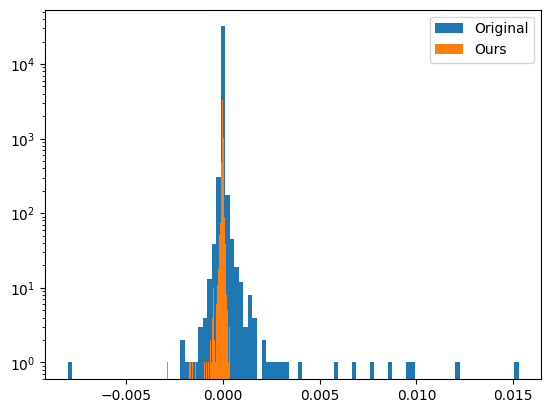

In [8]:
# Plot the distribution of scores. 

import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.hist(orig_scores.values(), bins=100, log=True, label="Original")
ax.hist(attribution.values(), bins=100, log=True, label="Ours")
ax.legend()

In [9]:
print(max(orig_scores.values()))
print(max(attribution.values()))

print(min(orig_scores.values()))
print(min(attribution.values()))

0.015274026
0.0003802104
-0.008004578
-0.0028547228
